In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

/Users/achille/opt/miniconda3/envs/cdae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


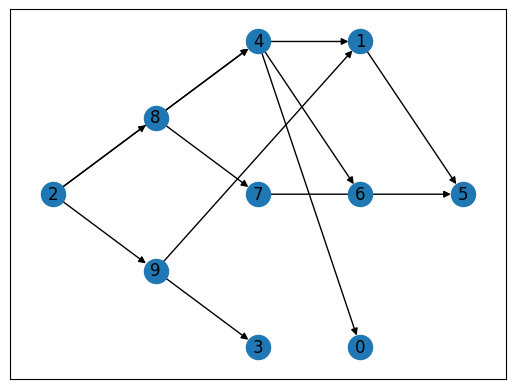

In [2]:
import networkx as nx
import torch

from causal_model import CausalModel, scale_mechanism
from simulated_data import random_dag, generate_gaussian_mlp_fixed_scale_mechanisms, draw_dag_topological_sort


import matplotlib.pyplot as plt
import seaborn as sns

from utils import set_random_seed_all
set_random_seed_all(0)

dag = random_dag(10, 12)

draw_dag_topological_sort(dag)

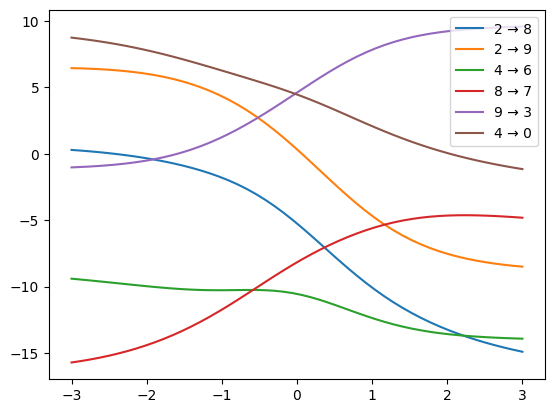

In [3]:
causal_model = CausalModel(dag)
observational_mechanisms = generate_gaussian_mlp_fixed_scale_mechanisms(
    causal_model, [100], scale=lambda x: (1-x/10), activation="sigmoid"
)
causal_model.set_causal_mechanisms(observational_mechanisms)

n_interventions = 10
tau = 0
# let's only intervene on one node at a time, by knocking down their mechanisms by tau
for i in range(n_interventions):
    nodes = [i]
    new_intervened_mechanisms = {
        n: scale_mechanism(observational_mechanisms[n], tau) for n in nodes
    }
    causal_model.set_intervention(str(i), new_intervened_mechanisms)
    
x = torch.linspace(-3,3,50)
for node in causal_model.nodes:
    parents = causal_model.get_parents(node)
    if len(parents) == 1:
        y = causal_model.causal_mechanisms[node].conditional_parameters_func({parents[0]: x})["loc"]
        plt.plot(x,y.detach(), label=f"{parents[0]} → {node}")
        
plt.legend()

In [4]:
causal_model.causal_mechanisms[2].conditional_parameters_func.extra_outputs

{'scale': 1.0}

In [5]:
causal_model.causal_mechanisms[8].conditional_parameters_func.extra_outputs

{'scale': 0.9}

<Axes: xlabel='2', ylabel='8'>

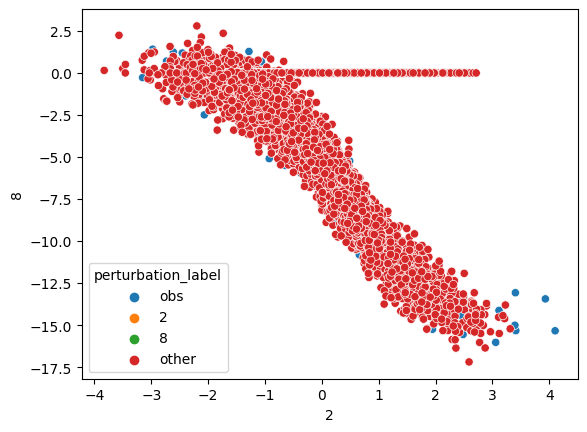

In [6]:
x, y = 2, 8

data = causal_model.generate_dataframe_from_all_distributions(1000, 1000)
data["perturbation_label"] = data["perturbation_label"].apply(
    lambda label: label if label in ["obs", x, y] else "other"
)

sns.scatterplot(data=data, x=x, y=y, hue="perturbation_label", hue_order=["obs", x, y, "other"])

<Axes: xlabel='1', ylabel='5'>

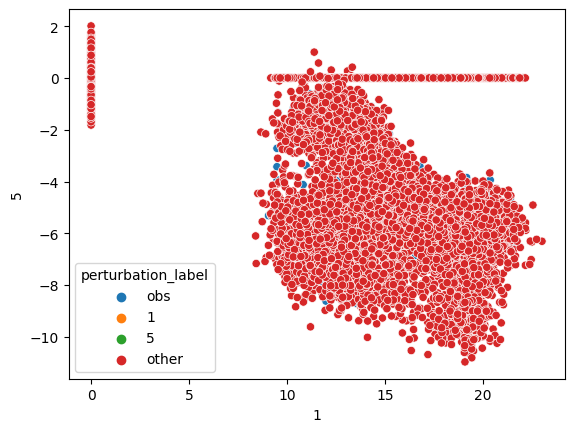

In [7]:
x, y = 1, 5

data = causal_model.generate_dataframe_from_all_distributions(1000, 1000)
data["perturbation_label"] = data["perturbation_label"].apply(
    lambda label: label if label in ["obs", x, y] else "other"
)

sns.scatterplot(data=data, x=x, y=y, hue="perturbation_label", hue_order=["obs", x, y, "other"])